Comment prédire le podium d'une course de Formule Un ? 

Librairies : 

In [2]:
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt


Chargement des données : 

In [3]:
drivers = pd.read_csv(os.path.join("donnees_formule_un", "drivers.csv")\
    , on_bad_lines='skip')
drivers.columns = drivers.columns.str.strip()
drivers["forename"] = drivers["forename"].str.replace('"', '').str.strip()
drivers["surname"] = drivers["surname"].str.replace('"', '').str.strip()
drivers["nom_complet"] = drivers["forename"] + " " + drivers["surname"]

constructors = pd.read_csv(os.path.join("donnees_formule_un", "constructors.csv"))
constructors.columns = constructors.columns.str.strip()

results = pd.read_csv(os.path.join("donnees_formule_un", "results.csv"))
results.columns = results.columns.str.strip()

races = pd.read_csv(os.path.join("donnees_formule_un", "races.csv"))
races.columns = races.columns.str.strip()
constructor_standings = pd.read_csv(os.path.join("donnees_formule_un", "constructor_standings.csv"))
constructor_standings.columns = constructor_standings.columns.str.strip()

"""qualifying = pd.read_csv(os.path.join("donnees_formule_un", "qualifying.csv"))
qualifying.columns = qualifying.columns.str.strip()"""

print("drivers")
print(drivers.columns)
print("construtors")
print(constructors.columns)
print("races")
print(races.columns)
print("results")
print(results.columns)
print("constructor_standings")
print(constructor_standings.columns)
"""print("qualifying")
print(qualifying.columns)"""

drivers
Index(['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob',
       'nationality', 'url', 'nom_complet'],
      dtype='object')
construtors
Index(['constructorId', 'constructorRef', 'name', 'nationality', 'url'], dtype='object')
races
Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url',
       'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time'],
      dtype='object')
results
Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId'],
      dtype='object')
constructor_standings
Index(['constructorStandingsId', 'raceId', 'constructorId', 'points',
       'position', 'positionText', 'wins'],
      dtype='object')


'print("qualifying")\nprint(qualifying.columns)'

Table énorme 

In [4]:
table_1 = pd.merge(races, results, on= "raceId")
table_2 = pd.merge(table_1, constructors, on = "constructorId")
table = pd.merge(table_2, drivers, on = "driverId")


print(table.columns)
#sélectionner les variables dans la table
table = table[['raceId', 'year', 'name_x', 'nom_complet', 'name_y', 'positionOrder', 'grid']]

# table triée sur les années 2023 et 2024 :
df = table[(table['year'] == 2023) | (table['year'] == 2024)| (table['year'] == 2022)| (table['year'] == 2021)]
df = df.drop_duplicates(subset=['raceId', 'nom_complet']) # éviter les doublons
print(df.head())


Index(['raceId', 'year', 'round', 'circuitId', 'name_x', 'date', 'time_x',
       'url_x', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'resultId', 'driverId', 'constructorId', 'number_x', 'grid', 'position',
       'positionText', 'positionOrder', 'points', 'laps', 'time_y',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'constructorRef', 'name_y',
       'nationality_x', 'url_y', 'driverRef', 'number_y', 'code', 'forename',
       'surname', 'dob', 'nationality_y', 'url', 'nom_complet'],
      dtype='object')
       raceId  year                            name_x      nom_complet  \
24930    1053  2021   "Emilia Romagna Grand Prix"       Max Verstappen   
24931    1053  2021   "Emilia Romagna Grand Prix"       Lewis Hamilton   
24932    1053  2021   "Emilia Romagna Grand Prix"         Lando Norris   
24933    1053  2021   "Emilia Roma

Info :
name_x = nom du circuit 
name_y = nom de constructeur 

Variables utilisées pour la régression logistique 

In [8]:
fusion = pd.merge(constructor_standings, races, on='raceId')
print(fusion.columns)
fusion = fusion[['raceId', 'constructorId', 'points', 'position', 'year', 'date']]
fusion_now = pd.merge(fusion, constructors, on='constructorId')
print(fusion_now.columns)


# Assure-toi que la colonne 'date' est bien de type datetime
fusion_now['date'] = fusion_now['date'].str.strip().str.replace('"', '')
fusion_now['date'] = pd.to_datetime(fusion_now['date'], format="%Y-%m-%d", errors='coerce')

# Filtrer uniquement pour les années 2023 et 2024
df_filtre = fusion_now[fusion_now['year'].isin([2020, 2021,2022, 2023, 2024])].copy()

# Trouver la date de la dernière course de chaque année
dernieres_dates = df_filtre.groupby('year')['date'].max().reset_index()
print("Dates des dernières courses :\n", dernieres_dates)

# Fusionner pour récupérer les raceId correspondants à ces dates
courses_finales = pd.merge(df_filtre, dernieres_dates, on=['year', 'date'])

# Sélectionner uniquement les colonnes utiles : position du constructeur à la dernière course
classement_final = courses_finales[['year', 'constructorId', 'name', 'position']].copy()
classement_final = classement_final.rename(columns={'position': 'position_fin_saison'})


classement_final = classement_final.rename(columns={'name': 'name_y'})
classement_final.drop(columns=['constructorId'], inplace=True)
# Décaler l'année pour que le classement de 2022 corresponde à 2023, etc.
classement_final['year'] = classement_final['year'] + 1


print(classement_final.columns)
print(classement_final.head())

fusion_2 = fusion_now[['raceId', 'position', 'name' , 'date']]
fusion_2 = fusion_2.rename(columns={'name': 'name_y'})
# On suppose que chaque ligne correspond à un pilote ou une écurie pour une course
# Tu dois avoir une colonne 'raceId', 'constructorId' (ou 'name_y') et 'position'

# Trier les données par écurie et date de course
fusion_2 = fusion_2.sort_values(by=['date'])

# Décaler la position par groupe d’écurie
fusion_2['position_prec'] = fusion_2.groupby('name_y')['position'].shift(1)
fusion_2.rename(columns={'position_prec': 'position_y'}, inplace=True)


fusion_2 = fusion_2[['raceId', 'position_y', 'name_y']]


if 'position_y' in df.columns:
    df = df.drop(columns=['position_y'])
    
df = pd.merge(df, fusion_2, on=['raceId', 'name_y'], how='left')





print(df.columns)
print(df.head(10))


Index(['constructorStandingsId', 'raceId', 'constructorId', 'points',
       'position', 'positionText', 'wins', 'year', 'round', 'circuitId',
       'name', 'date', 'time', 'url', 'fp1_date', 'fp1_time', 'fp2_date',
       'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time',
       'sprint_date', 'sprint_time'],
      dtype='object')
Index(['raceId', 'constructorId', 'points', 'position', 'year', 'date',
       'constructorRef', 'name', 'nationality', 'url'],
      dtype='object')
Dates des dernières courses :
    year       date
0  2020 2020-12-13
1  2021 2021-12-12
2  2022 2022-11-20
3  2023 2023-11-26
4  2024 2024-07-07
Index(['year', 'name_y', 'position_fin_saison'], dtype='object')
   year                        name_y  position_fin_saison
0  2021   "Mercedes"                                     1
1  2021   "Ferrari"                                      6
2  2021   "McLaren"                                      3
3  2021   "Racing Point"                                

In [9]:
# Nombre de victoires par pilote
nb_victoire_2_ans = df[df["positionOrder"] == 1].groupby("nom_complet").size()
# Ajouter un nom à la Série pour pouvoir la fusionner
nb_victoire_2_ans.name = 'nb_victoire_2_ans'
# Fusionner avec le DataFrame df
if 'nb_victoire_2_ans' in df.columns:
    df = df.drop(columns=['nb_victoire_2_ans'])

df = df.merge(nb_victoire_2_ans, on = "nom_complet", how = "left")
df["nb_victoire_2_ans"] = df["nb_victoire_2_ans"].fillna(0)


# Nombre de podium par pilote
nb_podium_2_ans = df[(df["positionOrder"] == 1) | (df["positionOrder"] == 2)\
    | (df["positionOrder"] == 3)].groupby("nom_complet").size()
# Ajouter un nom à la Série pour pouvoir la fusionner
nb_podium_2_ans.name = 'nb_podium_2_ans'
if 'nb_podium_2_ans' in df.columns:
    df = df.drop(columns=['nb_podium_2_ans'])
# Fusionner avec le DataFrame df
df = df.merge(nb_podium_2_ans, on = "nom_complet", how = "left")
# Remplir les NaN avec 0
df["nb_podium_2_ans"] = df["nb_podium_2_ans"].fillna(0)


# Position au départ de la course
# correspond à la variable grid de df


# Ecurie actuelle du pilote
df['name_y'] = df['name_y'].str.strip('" ') #pour avoir un nom prore
# Supprimer les anciennes colonnes d'ecurie si elles existent déjà
df = df.loc[:, ~df.columns.str.startswith('ecurie_')]
# Ecurie actuelle du pilote
df['ecurie'] = df['name_y'].str.strip()    # très important de STRIP ici aussi !!
# One-Hot Encoding
ecuries_encoded = pd.get_dummies(df['ecurie'], prefix='ecurie')
# Ajouter les colonnes au DataFrame
df = pd.concat([df, ecuries_encoded], axis=1)


# Convertir tout booléen en int (True → 1, False → 0)
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

# Position actuelle dans le championnat
# correspond à  la variable position de la table driver standings


df["grid_x_nb_podium"] = df["grid"] * df["nb_podium_2_ans"]
df["grid_x_nb_victoire"] = df["grid"] * df["nb_victoire_2_ans"]

for col in df.columns:
    if col.startswith("ecurie_"):
        col_name = col.replace("ecurie_", "")
        df[f"nb_podium_x_{col_name}"] = df["nb_podium_2_ans"] * df[col]

        
for col in df.columns: 
    if col.startswith("ecurie_"):
        col_name = col.replace("ecurie_", "")
        df[f"nb_victoire_x_{col_name}"] = df["nb_victoire_2_ans"] * df[col]


# Créer des interactions avec position_y et d'autres variables
df["position_y_x_nb_podium_2_ans"] = df["position_y"] * df["nb_podium_2_ans"]
df["position_y_x_nb_victoire_2_ans"] = df["position_y"] * df["nb_victoire_2_ans"]

# 1. Créer une variable position_y inverse (ajout de 1 pour éviter la division par 0)
df["position_y_inverse"] = 1 / (df["position_y"] + 1)

# 2. Créer des variables d'interaction pour chaque écurie
ecuries = [col for col in df.columns if col.startswith("ecurie_")]
for ecurie in ecuries:
    nom_colonne = f"{ecurie}_x_pos_inv"
    df[nom_colonne] = df[ecurie] * df["position_y_inverse"]






# Afficher les colonnes du DataFrame
df.columns = df.columns.str.strip()
print(df.columns)
print(df.head())


Index(['raceId', 'year', 'name_x', 'nom_complet', 'name_y', 'positionOrder',
       'grid', 'position_y', 'nb_victoire_2_ans', 'nb_podium_2_ans', 'ecurie',
       'ecurie_Alfa Romeo', 'ecurie_AlphaTauri', 'ecurie_Alpine F1 Team',
       'ecurie_Aston Martin', 'ecurie_Ferrari', 'ecurie_Haas F1 Team',
       'ecurie_McLaren', 'ecurie_Mercedes', 'ecurie_RB F1 Team',
       'ecurie_Red Bull', 'ecurie_Sauber', 'ecurie_Williams',
       'grid_x_nb_podium', 'grid_x_nb_victoire', 'nb_podium_x_Alfa Romeo',
       'nb_podium_x_AlphaTauri', 'nb_podium_x_Alpine F1 Team',
       'nb_podium_x_Aston Martin', 'nb_podium_x_Ferrari',
       'nb_podium_x_Haas F1 Team', 'nb_podium_x_McLaren',
       'nb_podium_x_Mercedes', 'nb_podium_x_RB F1 Team',
       'nb_podium_x_Red Bull', 'nb_podium_x_Sauber', 'nb_podium_x_Williams',
       'nb_victoire_x_Alfa Romeo', 'nb_victoire_x_AlphaTauri',
       'nb_victoire_x_Alpine F1 Team', 'nb_victoire_x_Aston Martin',
       'nb_victoire_x_Ferrari', 'nb_victoire_x_Haas 

Régression logistique 

Une accuracy de 0.88 signifie que 88% des observations testées ont été bien classées. 

Matrice de confusion : 160 vrais négatifs ; 19 vrais positifs ; 13 faux négatifs ; 12 faux positifs 

Rapport de classification : racall = taux de faux négatifs, le modèle rate des podium ou des non podium, plus il est faible plus le modèle rate ; precision = plus elle est faible plus le modèle prédit à tord ; F1 score = équilibre de ces deux aspects 

Conclusion : pour l'instant le modèle est déséquilibré, il est très bon pour prédire pas podium mais beaucoup moins pour prédire le podium. 



Pistes d'amélioration : tester la régression logistique avec class_weight="balanced", ce qui compense automatiquement le déséquilibre entre les classes.

Accuracy du modèle pour la prédiction du podium : 0.92


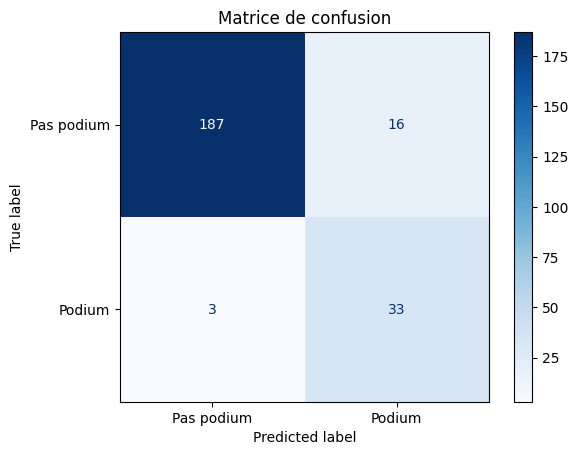

Rapport de classification :
              precision    recall  f1-score   support

  Pas podium       0.98      0.92      0.95       203
      Podium       0.67      0.92      0.78        36

    accuracy                           0.92       239
   macro avg       0.83      0.92      0.86       239
weighted avg       0.94      0.92      0.93       239

                            feature  coefficient
6             ecurie_Alpine F1 Team     1.447675
10                   ecurie_McLaren     1.245314
19           nb_podium_x_AlphaTauri     0.439825
39           nb_victoire_x_Red Bull     0.379355
44               position_y_inverse     0.359985
52        ecurie_Mercedes_x_pos_inv     0.278422
32     nb_victoire_x_Alpine F1 Team     0.246072
3                   nb_podium_2_ans     0.234485
49         ecurie_Ferrari_x_pos_inv     0.210508
25             nb_podium_x_Mercedes     0.184923
21         nb_podium_x_Aston Martin     0.169284
54        ecurie_Red Bull_x_pos_inv     0.164014
29      

In [165]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Variable cible : sur le podium ou non
df["sur_podium"] = df["positionOrder"].isin([1, 2, 3]).astype(int)

# 2. Convertir les booléens en 0/1
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

# 3. Définir les features (X) et la cible (y)
colonnes_a_exclure = ['raceId', 'year', 'name_x', 'name_y', 'nom_complet', 'ecurie', 'sur_podium', 'positionOrder']
# 4. Séparer les jeux d'entraînement et de test
df_train = df[(df['year'] == 2021)|(df['year'] == 2022)|(df['year'] == 2023)].copy()
df_test = df[(df['year'] == 2024)].copy()

# 5. Créer X et y
X_train = df_train.drop(columns=colonnes_a_exclure).fillna(0)
y_train = df_train['sur_podium']

X_test = df_test.drop(columns=colonnes_a_exclure).fillna(0)
y_test = df_test['sur_podium']

# Aligner les colonnes
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 5. Entraîner le modèle
model = LogisticRegression(max_iter=5000, class_weight="balanced")
model.fit(X_train, y_train)


# 6. Prédictions avec ajustement du seuil
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.7).astype(int)

# 7. Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle pour la prédiction du podium : {accuracy:.2f}")

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


# 1. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pas podium", "Podium"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

# 2. Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=["Pas podium", "Podium"]))


#Poids des variables
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', ascending=False)

print(coef_df)
